In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hadicanmunis","key":"f7df984e4726af6a5db846149e807b9c"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d hadicanmunis/plantvillage

100% 355M/355M [00:09<00:00, 41.8MB/s]
100% 355M/355M [00:09<00:00, 39.1MB/s]


In [4]:
!unzip -qq plantvillage.zip

In [5]:
import os, shutil, pathlib
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [6]:
train_dir = pathlib.Path("/content/Plant_leave_diseases_dataset_without_augmentation/train")
test_dir = pathlib.Path("/content/Plant_leave_diseases_dataset_without_augmentation/test")

In [7]:
from tensorflow.keras.utils import image_dataset_from_directory

image_size = (256, 256)
batch_size = 64

train_ds, val_ds = image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    validation_split=0.2,
    subset="both",
    image_size=image_size,
    seed=42,
    batch_size=batch_size,
)

test_ds = image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False)

Found 18195 files belonging to 15 classes.
Using 14556 files for training.
Using 3639 files for validation.
Found 4591 files belonging to 15 classes.


In [8]:
for data_batch, labels_batch in train_ds:
     print("data batch shape:", data_batch.shape)
     print("labels batch shape:", labels_batch.shape)
     break

data batch shape: (64, 256, 256, 3)
labels batch shape: (64, 15)


In [9]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.4),
        layers.RandomZoom(0.2),
        layers.RandomBrightness(0.5),
        layers.RandomContrast(0.2),
        layers.RandomCrop(180, 180)
    ]
)

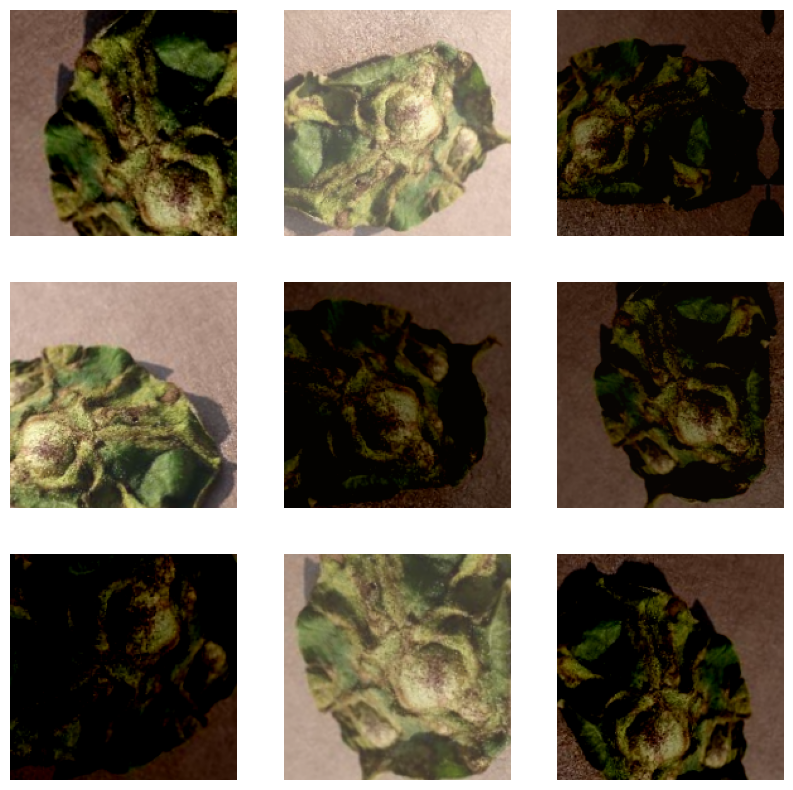

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(15, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 180, 180, 3)          0         ['input_1[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 180, 180, 3)          0         ['sequential[0][0]']          
                                                                                                  
 conv2d (Conv2D)             (None, 176, 176, 32)         2400      ['rescaling[0][0]']           
                                                                                              

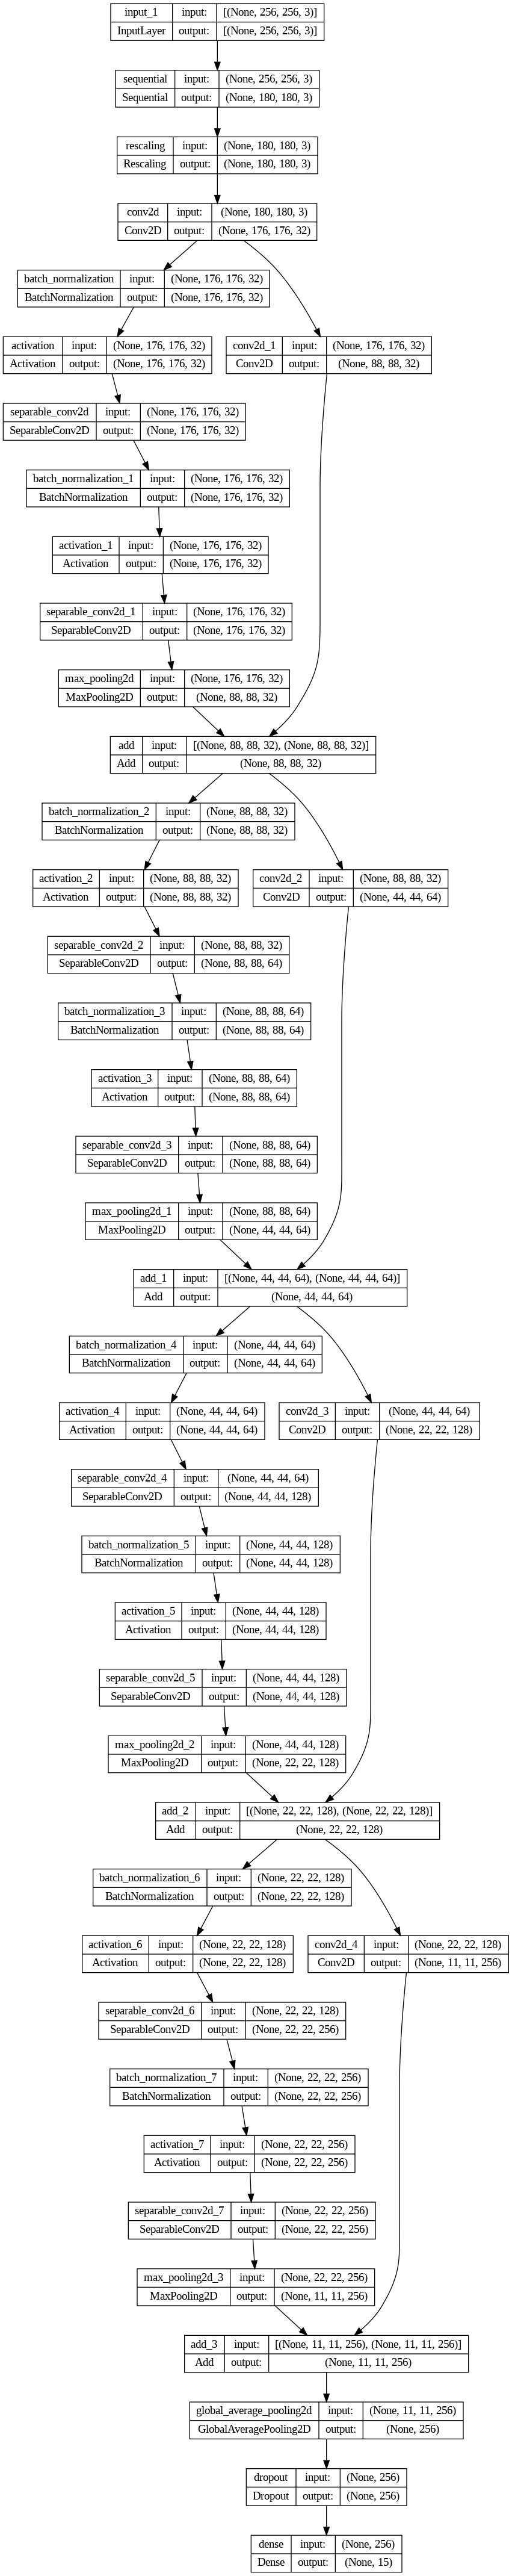

In [13]:
keras.utils.plot_model(model, show_shapes=True)

In [14]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [15]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="first_baseline_model_4_100epochs.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=callbacks)

Epoch 1/100
228/228 [==============================] - 35s 104ms/step - loss: 1.8698 - accuracy: 0.3951 - val_loss: 2.5843 - val_accuracy: 0.1044
Epoch 2/100
228/228 [==============================] - 22s 97ms/step - loss: 1.2741 - accuracy: 0.5829 - val_loss: 2.1182 - val_accuracy: 0.3240
Epoch 3/100
228/228 [==============================] - 22s 97ms/step - loss: 0.9566 - accuracy: 0.6831 - val_loss: 0.8779 - val_accuracy: 0.7032
Epoch 4/100
228/228 [==============================] - 22s 96ms/step - loss: 0.7788 - accuracy: 0.7448 - val_loss: 1.8208 - val_accuracy: 0.5562
Epoch 5/100
228/228 [==============================] - 22s 97ms/step - loss: 0.6616 - accuracy: 0.7863 - val_loss: 0.5510 - val_accuracy: 0.8225
Epoch 6/100
228/228 [==============================] - 22s 97ms/step - loss: 0.5938 - accuracy: 0.8043 - val_loss: 0.5296 - val_accuracy: 0.8288
Epoch 7/100
228/228 [==============================] - 22s 96ms/step - loss: 0.5433 - accuracy: 0.8204 - val_loss: 0.7291 - val_a

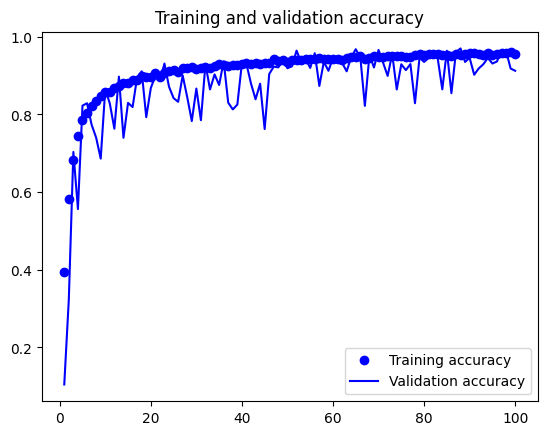

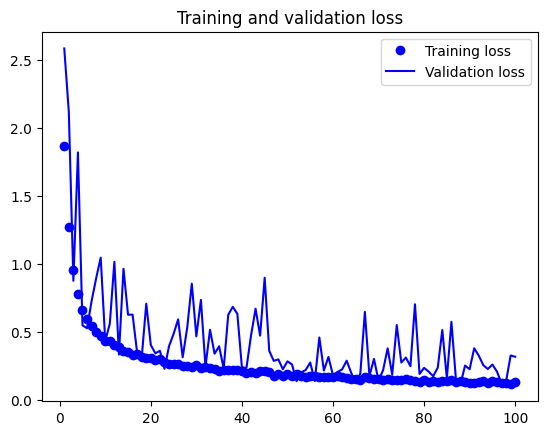

In [16]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [17]:
test_model = keras.models.load_model("first_baseline_model_4_100epochs.keras")
test_loss, test_acc = test_model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

72/72 [==============================] - 3s 39ms/step - loss: 0.1097 - accuracy: 0.9625
Test accuracy: 0.963


In [18]:
y_pred = test_model.predict(test_ds)
predicted_labels = np.argmax(y_pred, axis=1)

72/72 [==============================] - 3s 31ms/step


In [19]:
import tensorflow as tf

true_categories = tf.concat([y for x, y in test_ds], axis=0)
y_true = np.argmax(true_categories, axis=1)

In [20]:
y_true

array([ 0,  0,  0, ..., 14, 14, 14])

In [21]:
predicted_labels

array([ 0,  0,  0, ..., 14, 14, 14])

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, predicted_labels)

In [23]:
print(classification_report(y_true, predicted_labels, target_names = train_ds.class_names))

                                               precision    recall  f1-score   support

                Pepper,_bell___Bacterial_spot       0.64      1.00      0.78       220
                       Pepper,_bell___healthy       0.84      0.87      0.85       296
                        Potato___Early_blight       0.88      0.83      0.86       200
                         Potato___Late_blight       1.00      0.81      0.90       200
                             Potato___healthy       0.91      0.91      0.91        32
                      Tomato___Bacterial_spot       0.98      0.91      0.95       426
                        Tomato___Early_blight       0.83      0.89      0.86       200
                         Tomato___Late_blight       0.96      0.91      0.94       381
                           Tomato___Leaf_Mold       0.97      0.99      0.98       192
                  Tomato___Septoria_leaf_spot       0.93      0.89      0.91       355
Tomato___Spider_mites Two-spotted_spider_m

<Axes: >

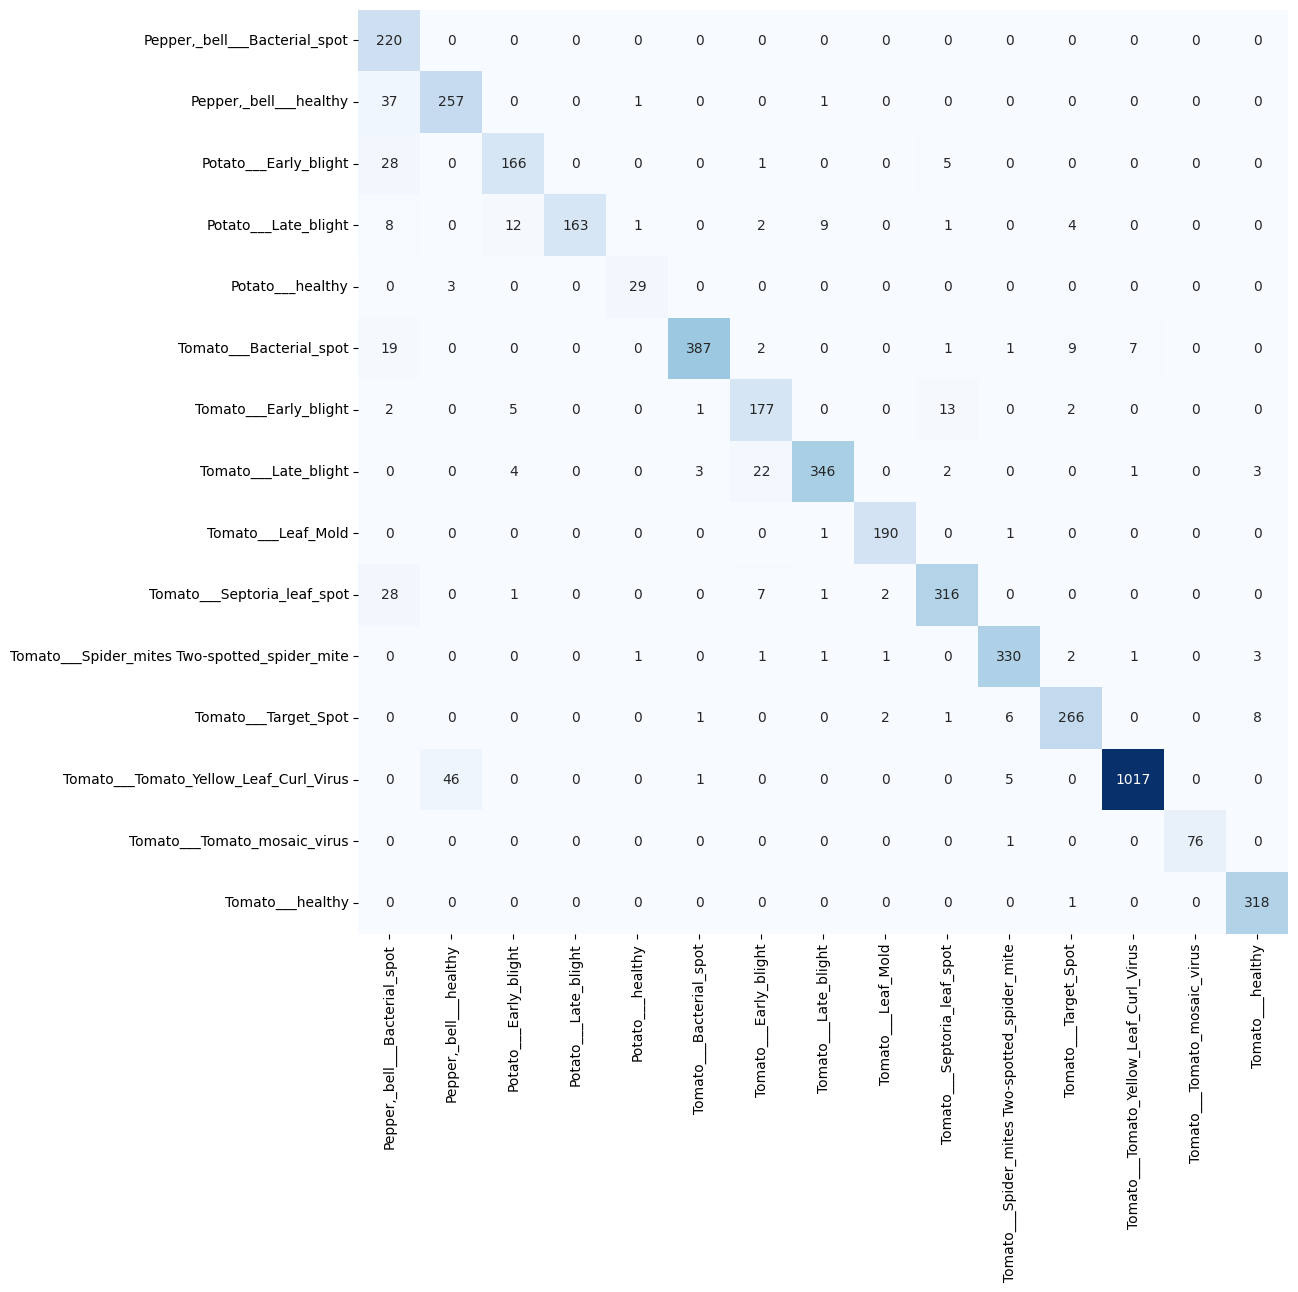

In [24]:
import seaborn as sns

plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap="Blues", xticklabels=train_ds.class_names, yticklabels=train_ds.class_names)